# ⚠️ Napomena

Ovaj notebook je **obrađen i delimično izmenjen** (dopunjena objašnjenja, sređene formule i kod).
Nije formalno verifikovan niti detaljno proveren na moguće greške, pa ga koristite **na sopstvenu odgovornost**.


Milan R. Rapaić,
Mirna N. Kapetina,
Novembar 2020

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import LogNorm

# Metod najbržeg pada (gradijentni spust)

Cilj je da nađemo minimum diferencijabilne funkcije:

\begin{align}
\min_{\mathbf{x}\in\mathbb{R}^n} f(\mathbf{x}).
\end{align}

Osnovna ideja gradijentnog spusta: u svakoj iteraciji pomeramo trenutno rešenje u smeru **negativnog gradijenta**, jer gradijent pokazuje pravac najbržeg rasta funkcije.

Gradijent funkcije je vektor parcijalnih izvoda:

\begin{align}
\nabla f(\mathbf{x}) =
\begin{bmatrix}
\frac{\partial f}{\partial x_1} &
\frac{\partial f}{\partial x_2} &
\dots &
\frac{\partial f}{\partial x_n}
\end{bmatrix}^T.
\end{align}

Promena u $k$-toj iteraciji:

\begin{align}
\mathbf{x}_{k+1} = \mathbf{x}_k - \gamma \, \nabla f(\mathbf{x}_k),
\end{align}

gde je $\gamma>0$ **dužina koraka** (learning rate). Ako je $\gamma$ prevelik, iteracije mogu da osciluju ili divergiraju; ako je premali, konvergencija je spora.

Kriterijumi zaustavljanja su tipično:
- $\lVert \nabla f(\mathbf{x}_k) \rVert \le \varepsilon$ (gradijent je „dovoljno mali”), ili
- maksimalan broj iteracija $k \ge N$.

U nastavku koristimo test funkciju:

\begin{align}
f(x_1, x_2) = x_1^2 + 10x_2^2,
\end{align}

koja ima izdužene konture (različite krivine po osama). Upravo na ovakvim funkcijama „običan“ gradijentni spust često pravi cik-cak putanju, pa je dobar primer za poređenje modifikacija.


In [2]:
def steepest_descent(gradf, x0, gamma=0.1, epsilon=1e-6, max_iter=200):
    """Gradijentni spust sa konstantnim korakom.

    Args:
        gradf: funkcija koja vraća gradijent abla f(x) (isti oblik kao x).
        x0: početna tačka (lista/np.array dužine n).
        gamma: korak (learning rate) > 0.
        epsilon: tolerancija zaustavljanja po normi gradijenta.
        max_iter: maksimalan broj iteracija.

    Returns:
        x: pronađeno rešenje (np.array oblika (n,)).
        path: putanja (lista tačaka), korisno za vizualizaciju.
    """
    x = np.asarray(x0, dtype=float).reshape(-1)
    path = [x.copy()]

    for _ in range(max_iter):
        g = np.asarray(gradf(x), dtype=float).reshape(-1)
        if np.linalg.norm(g) <= epsilon:
            break
        x = x - gamma * g
        path.append(x.copy())

    return x, path


In [3]:
def func1(x):
    """Test funkcija: f(x1,x2) = x1^2 + 10*x2^2."""
    x = np.asarray(x, dtype=float).reshape(-1)
    return x[0]**2 + 10.0 * x[1]**2


In [4]:
def func1_grad(x):
    """Gradijent test funkcije: 
abla f = [2*x1, 20*x2]."""
    x = np.asarray(x, dtype=float).reshape(-1)
    return np.array([2.0 * x[0], 20.0 * x[1]])


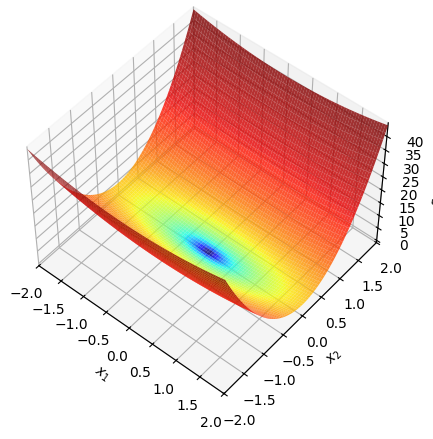

In [5]:
xmin, xmax, xstep = -2, 2, 0.05
ymin, ymax, ystep = -2, 2, 0.05

x1, x2 = np.meshgrid(
    np.arange(xmin, xmax + xstep, xstep),
    np.arange(ymin, ymax + ystep, ystep)
)

z = x1**2 + 10.0 * x2**2

fig = plt.figure(figsize=(8, 5))
ax = plt.axes(projection='3d', elev=50, azim=-50)

ax.plot_surface(
    x1, x2, z,
    norm=LogNorm(),
    rstride=1, cstride=1,
    edgecolor='none',
    alpha=0.8,
    cmap=plt.cm.jet
)

ax.set_xlabel('$x_1$')
ax.set_ylabel('$x_2$')
ax.set_zlabel('$f(x_1,x_2)$')
ax.set_xlim((xmin, xmax))
ax.set_ylim((ymin, ymax))
plt.show()


In [6]:
rez_sg, path_sg = steepest_descent(func1_grad, x0=[1, 2], gamma=0.05, epsilon=1e-6, max_iter=200)
print('Rešenje (SGD/SD):', rez_sg)
print('f(x) =', func1(rez_sg))


Rešenje (SGD/SD): [4.84692503e-07 0.00000000e+00]
f(x) = 2.34926822809292e-13


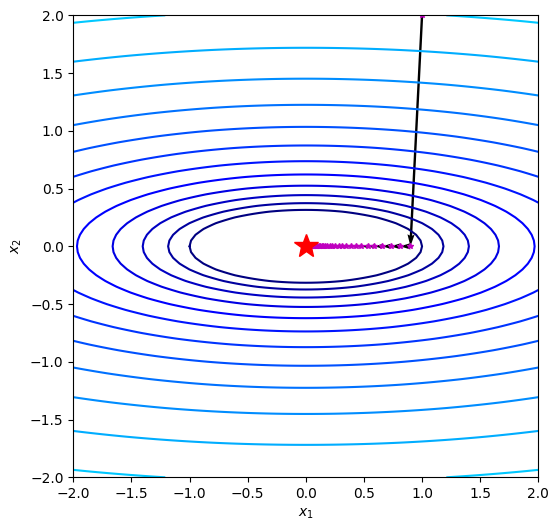

In [7]:
path = np.array(path_sg)

fig, ax = plt.subplots(figsize=(6, 6))
ax.contour(x1, x2, z, levels=np.logspace(0, 5, 35), norm=LogNorm(), cmap=plt.cm.jet)

ax.quiver(
    path[:-1, 0], path[:-1, 1],
    path[1:, 0] - path[:-1, 0],
    path[1:, 1] - path[:-1, 1],
    scale_units='xy', angles='xy', scale=1, color='k'
)

ax.plot(path[:, 0], path[:, 1], 'm*', markersize=4)
ax.plot(rez_sg[0], rez_sg[1], 'r*', markersize=18)

ax.set_xlabel('$x_1$')
ax.set_ylabel('$x_2$')
ax.set_xlim((xmin, xmax))
ax.set_ylim((ymin, ymax))
plt.show()


Kod standardnog gradijentnog spusta dužina pomeraja zavisi od norme gradijenta: kada je gradijent veliki, pomeraji su veliki; kada je mali, pomeraji postaju sve manji.

Jedna jednostavna modifikacija je da se **normalizuje gradijent**, pa se u svakoj iteraciji pravi pomeraj približno stalne dužine $\gamma$:

\begin{align}
\mathbf{x}_{k+1} = \mathbf{x}_k - \gamma \, \frac{\nabla f(\mathbf{x}_k)}{\lVert \nabla f(\mathbf{x}_k) \rVert}.
\end{align}

Ovaj pristup može da bude koristan kao intuicija („uvek idem istu distancu u smeru pada”), ali u praksi često nije stabilan blizu minimuma (može da „preskače“ oko rešenja) i zato se češće koriste sofisticiranije strategije za izbor koraka (npr. line-search) ili metode sa momentom/adaptacijom.

In [8]:
def steepest_descent_fixed_step(gradf, x0, step_len=0.5, epsilon=1e-6, max_iter=200, eps_div=1e-12):
    """Gradijentni spust sa približno konstantnom dužinom koraka.

    x_{k+1} = x_k - step_len * g / ||g||

    Args:
        gradf: gradijent 
abla f(x).
        x0: početna tačka.
        step_len: željena dužina pomeraja po iteraciji.
        epsilon: tolerancija zaustavljanja po normi gradijenta.
        max_iter: maksimalan broj iteracija.
        eps_div: mali broj da izbegnemo deljenje nulom.

    Returns:
        x, path
    """
    x = np.asarray(x0, dtype=float).reshape(-1)
    path = [x.copy()]

    for _ in range(max_iter):
        g = np.asarray(gradf(x), dtype=float).reshape(-1)
        ng = np.linalg.norm(g)
        if ng <= epsilon:
            break
        x = x - step_len * (g / (ng + eps_div))
        path.append(x.copy())

    return x, path


In [9]:
rez_fix, path_fix = steepest_descent_fixed_step(func1_grad, x0=[1, 2], step_len=0.5, epsilon=1e-6, max_iter=200)
print('Rešenje (fixed step length):', rez_fix)
print('f(x) =', func1(rez_fix))


Rešenje (fixed step length): [6.52161718e-31 3.81824547e-01]
f(x) = 1.457899844297437


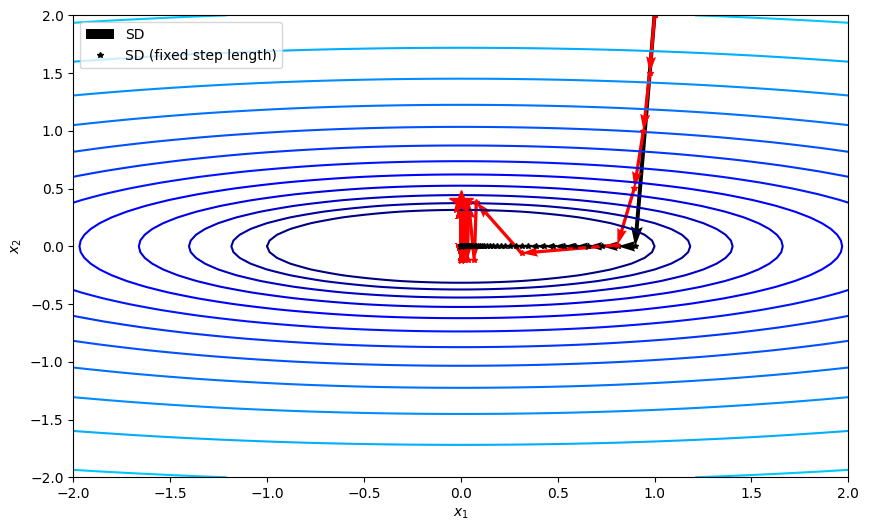

In [10]:
path1 = np.array(path_sg)
path2 = np.array(path_fix)

fig, ax = plt.subplots(figsize=(10, 6))
ax.contour(x1, x2, z, levels=np.logspace(0, 5, 35), norm=LogNorm(), cmap=plt.cm.jet)

ax.quiver(path1[:-1,0], path1[:-1,1], path1[1:,0]-path1[:-1,0], path1[1:,1]-path1[:-1,1],
          scale_units='xy', angles='xy', scale=1, color='k')
ax.plot(path1[:,0], path1[:,1], 'k*', markersize=4)

ax.quiver(path2[:-1,0], path2[:-1,1], path2[1:,0]-path2[:-1,0], path2[1:,1]-path2[:-1,1],
          scale_units='xy', angles='xy', scale=1, color='r')
ax.plot(path2[:,0], path2[:,1], 'r*', markersize=4)

plt.legend(['SD', 'SD (fixed step length)'])
ax.plot(rez_fix[0], rez_fix[1], 'r*', markersize=18)

ax.set_xlabel('$x_1$')
ax.set_ylabel('$x_2$')
ax.set_xlim((xmin, xmax))
ax.set_ylim((ymin, ymax))
plt.show()


Kod izduženih kontura (kao ovde), običan gradijentni spust često pravi cik-cak putanju. Metoda sa konstantnom dužinom koraka dodatno može da bude problematična blizu minimuma, jer korak ne „opada“ prirodno kako se približavamo rešenju.

Zato se u praksi često koriste modifikacije koje:
- ublažavaju oscilacije (momentum, Nesterov),
- automatski podešavaju korak po koordinatama (AdaGrad, RMSProp, Adam).


# Osnovne modifikacije metode najbržeg pada

## Gradijentna metoda sa momentom (Momentum)

Ideja momenta: umesto da se oslanjamo samo na tekući gradijent, pamtimo i „inerciju“ kretanja iz prethodnih iteracija. To pomaže da se ublaže oscilacije (npr. levo-desno u uskim dolinama) i često ubrzava kretanje u stabilnom smeru.

U obliku koji koristimo u kodu:

\begin{align}
\mathbf{v}_k &= \omega\, \mathbf{v}_{k-1} + \gamma\, \nabla f(\mathbf{x}_k), \\
\mathbf{x}_{k+1} &= \mathbf{x}_k - \mathbf{v}_k,
\end{align}

gde je:
- $\mathbf{v}_k$ „brzina“ (akumulirani smer),
- $\omega\in[0,1)$ koeficijent momenta (tipično 0.9),
- $\gamma$ osnovni korak.

Intuicija: ako se gradijenti duže vreme slažu u istom smeru, $\mathbf{v}$ raste i ubrzava kretanje; ako gradijent menja smer (oscilacije), momentum ih ublažava.


In [11]:
def steepest_descent_momentum(gradf, x0, gamma=0.05, omega=0.9, epsilon=1e-6, max_iter=200):
    """Gradijentni spust sa momentom (heavy-ball).

    v_k = omega * v_{k-1} + gamma * grad f(x_k)
    x_{k+1} = x_k - v_k
    """
    x = np.asarray(x0, dtype=float).reshape(-1)
    v = np.zeros_like(x)
    path = [x.copy()]

    for _ in range(max_iter):
        g = np.asarray(gradf(x), dtype=float).reshape(-1)
        if np.linalg.norm(g) <= epsilon:
            break
        v = omega * v + gamma * g
        x = x - v
        path.append(x.copy())

    return x, path


In [12]:
rez_mom, path_mom = steepest_descent_momentum(func1_grad, x0=[1, 2], gamma=0.05, omega=0.5, epsilon=1e-6, max_iter=200)
print('Rešenje (momentum):', rez_mom)
print('f(x) =', func1(rez_mom))


Rešenje (momentum): [ 1.11536669e-07 -3.69915227e-08]
f(x) = 2.612415608128697e-14


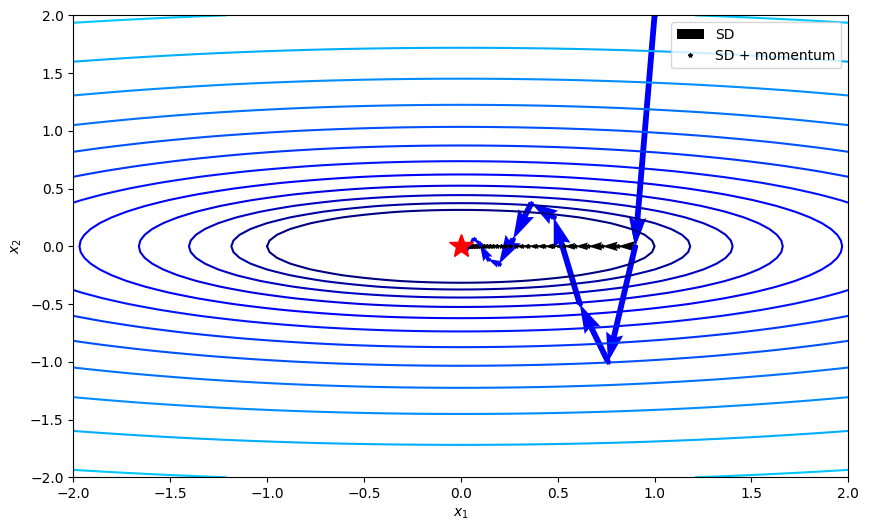

In [13]:
path1 = np.array(path_sg)
path2 = np.array(path_mom)

fig, ax = plt.subplots(figsize=(10, 6))
ax.contour(x1, x2, z, levels=np.logspace(0, 5, 35), norm=LogNorm(), cmap=plt.cm.jet)

ax.quiver(path1[:-1,0], path1[:-1,1], path1[1:,0]-path1[:-1,0], path1[1:,1]-path1[:-1,1],
          scale_units='xy', angles='xy', scale=1, color='k')
ax.plot(path1[:,0], path1[:,1], 'k*', markersize=3)

ax.quiver(path2[:-1,0], path2[:-1,1], path2[1:,0]-path2[:-1,0], path2[1:,1]-path2[:-1,1],
          scale_units='xy', angles='xy', scale=1, color='b')
ax.plot(path2[:,0], path2[:,1], 'b*', markersize=3)

plt.legend(['SD', 'SD + momentum'])
ax.plot(rez_mom[0], rez_mom[1], 'r*', markersize=18)

ax.set_xlabel('$x_1$')
ax.set_ylabel('$x_2$')
ax.set_xlim((xmin, xmax))
ax.set_ylim((ymin, ymax))
plt.show()


## Ubrzani gradijent Nesterova (Nesterov momentum)

Nesterovljev momentum je sličan klasičnom momentumu, ali uvodi ideju „pogleda unapred“: gradijent ne računamo u trenutnoj tački, već u tački koju bismo dobili kada bismo napravili deo pomeraja usled momenta.

U obliku koji koristimo:

\begin{align}
\mathbf{x}'_k &= \mathbf{x}_k - \omega\, \mathbf{v}_{k-1}, \\
\mathbf{v}_k &= \omega\, \mathbf{v}_{k-1} + \gamma\, \nabla f(\mathbf{x}'_k), \\
\mathbf{x}_{k+1} &= \mathbf{x}_k - \mathbf{v}_k.
\end{align}

Praktično, ovaj „look-ahead“ često daje stabilnije i brže ponašanje u odnosu na običan momentum.

In [14]:
def nesterov_gradient(gradf, x0, gamma=0.05, omega=0.9, epsilon=1e-6, max_iter=200):
    """Nesterov momentum (look-ahead)."""
    x = np.asarray(x0, dtype=float).reshape(-1)
    v = np.zeros_like(x)
    path = [x.copy()]

    for _ in range(max_iter):
        x_lookahead = x - omega * v
        g = np.asarray(gradf(x_lookahead), dtype=float).reshape(-1)
        if np.linalg.norm(g) <= epsilon:
            break
        v = omega * v + gamma * g
        x = x - v
        path.append(x.copy())

    return x, path


In [15]:
rez_nes, path_nes = nesterov_gradient(func1_grad, x0=[1, 2], gamma=0.05, omega=0.5, epsilon=1e-6, max_iter=200)
print('Rešenje (Nesterov):', rez_nes)
print('f(x) =', func1(rez_nes))


Rešenje (Nesterov): [4.77832152e-07 0.00000000e+00]
f(x) = 2.28323565219915e-13


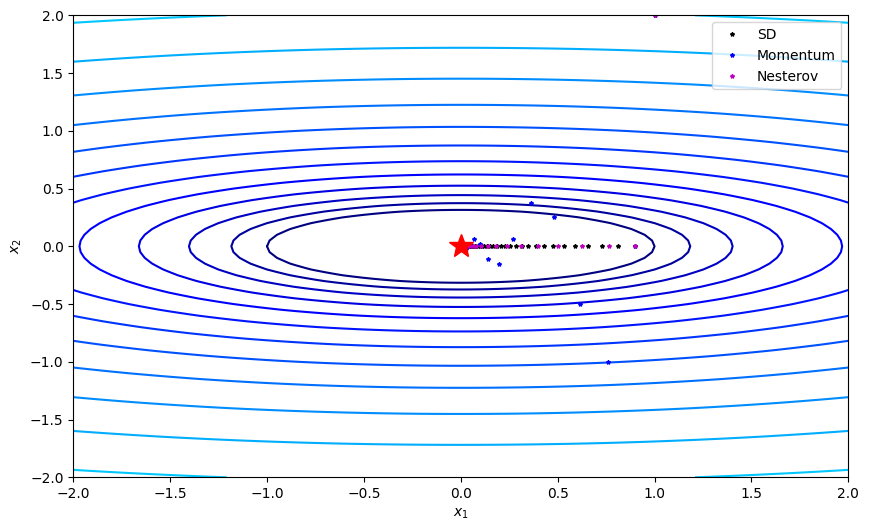

In [16]:
path1 = np.array(path_sg)
path2 = np.array(path_mom)
path3 = np.array(path_nes)

fig, ax = plt.subplots(figsize=(10, 6))
ax.contour(x1, x2, z, levels=np.logspace(0, 5, 35), norm=LogNorm(), cmap=plt.cm.jet)

ax.plot(path1[:,0], path1[:,1], 'k*', markersize=3)
ax.plot(path2[:,0], path2[:,1], 'b*', markersize=3)
ax.plot(path3[:,0], path3[:,1], 'm*', markersize=3)

plt.legend(['SD', 'Momentum', 'Nesterov'])
ax.plot(rez_nes[0], rez_nes[1], 'r*', markersize=18)

ax.set_xlabel('$x_1$')
ax.set_ylabel('$x_2$')
ax.set_xlim((xmin, xmax))
ax.set_ylim((ymin, ymax))
plt.show()


# Adaptivni gradijentni metodi

Kod standardnog gradijentnog spusta jedan parametar $\gamma$ određuje brzinu učenja u svim pravcima. Ako je funkcija „strma“ po jednoj osi, a „blaga“ po drugoj, isti korak često nije dobar kompromis: po strmoj osi treba ići pažljivo (mali koraci), a po blagoj osi brže (veći koraci).

Adaptivne metode rešavaju ovo tako što uvode **različite efektivne korake po koordinatama**, na osnovu istorije gradijenata.

## AdaGrad

Neka je $g_{k,i}$ gradijent kriterijuma optimalnosti po $i$-toj promenljivoj u $k$-toj iteraciji:

\begin{align}
g_{k,i} = \nabla f(\mathbf{x}_k)_i = \frac{\partial f(\mathbf{x}_k)}{\partial x_i}.
\end{align}

Označimo sa $G_{k,i}$ sumu kvadrata gradijenata po $i$-toj promenljivoj zaključno sa $k$-tom iteracijom:

\begin{align}
G_{k,i} = \sum_{j=0}^{k} g_{j,i}^2.
\end{align}

AdaGrad koristi sledeću promenu:

\begin{align}
x_{k+1,i} = x_{k,i} - \frac{\gamma}{\sqrt{G_{k,i} + \varepsilon_1}}\, g_{k,i},
\end{align}

gde je $\varepsilon_1$ mali parametar (tipično $\sim 10^{-8}$) koji sprečava deljenje nulom i stabilizuje prve iteracije.

**Intuicija:** ako je neka koordinata često imala velike gradijente, $G_{k,i}$ raste, pa se efektivni korak po toj koordinati smanjuje.


In [17]:
def adagrad_gradient(gradf, x0, gamma=0.2, epsilon1=1e-8, epsilon=1e-6, max_iter=200):
    """AdaGrad (per-parameter learning rate).

    x_{k+1} = x_k - (gamma / sqrt(G + epsilon1)) * g
    G = sum of squared gradients (po koordinatama)

    Returns:
        x, path, lr_hist (efektivni koraci po koordinatama kroz iteracije)
    """
    x = np.asarray(x0, dtype=float).reshape(-1)
    G = np.zeros_like(x)
    path = [x.copy()]
    lr_hist = []

    for _ in range(max_iter):
        g = np.asarray(gradf(x), dtype=float).reshape(-1)
        if np.linalg.norm(g) <= epsilon:
            break
        G = G + g * g
        lr = gamma / (np.sqrt(G) + epsilon1)
        x = x - lr * g
        path.append(x.copy())
        lr_hist.append(lr.copy())

    return x, path, np.array(lr_hist)


In [18]:
rez_ada, path_ada, lr_ada = adagrad_gradient(func1_grad, x0=[1, 2], gamma=0.2, epsilon1=1e-8, epsilon=1e-6, max_iter=200)
print('Rešenje (AdaGrad):', rez_ada)
print('f(x) =', func1(rez_ada))


Rešenje (AdaGrad): [1.70172321e-10 2.21687807e-03]
f(x) = 4.914548388560435e-05


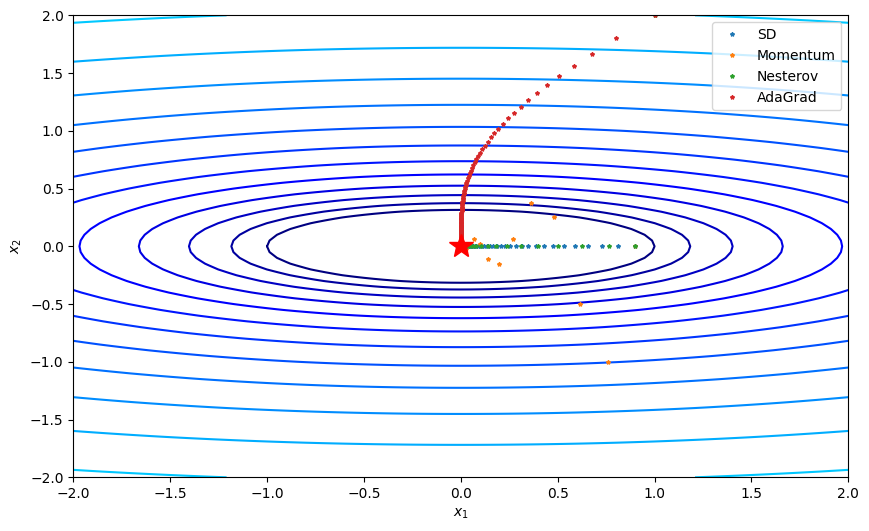

In [19]:
paths = {
    'SD': np.array(path_sg),
    'Momentum': np.array(path_mom),
    'Nesterov': np.array(path_nes),
    'AdaGrad': np.array(path_ada),
}

fig, ax = plt.subplots(figsize=(10, 6))
ax.contour(x1, x2, z, levels=np.logspace(0, 5, 35), norm=LogNorm(), cmap=plt.cm.jet)

for name, p in paths.items():
    ax.plot(p[:,0], p[:,1], marker='*', linestyle='None', markersize=3)

plt.legend(list(paths.keys()))
ax.plot(rez_ada[0], rez_ada[1], 'r*', markersize=18)

ax.set_xlabel('$x_1$')
ax.set_ylabel('$x_2$')
ax.set_xlim((xmin, xmax))
ax.set_ylim((ymin, ymax))
plt.show()


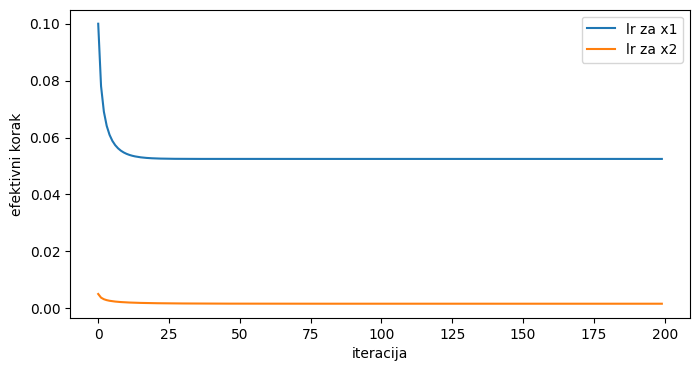

In [20]:
# Efektivni koraci (learning rate) po koordinatama tokom iteracija
plt.figure(figsize=(8, 4))
plt.plot(lr_ada[:, 0], label='lr za x1')
plt.plot(lr_ada[:, 1], label='lr za x2')
plt.xlabel('iteracija')
plt.ylabel('efektivni korak')
plt.legend()
plt.show()


## RMSProp

RMSProp je sličan AdaGrad-u, ali izbegava problem da $G$ raste neograničeno i da koraci vremenom postanu previše mali. Umesto sume kvadrata gradijenata, koristi **eksponencijalni pokretni prosek**:

\begin{align}
G_{k+1,i} = \omega G_{k,i} + (1-\omega)\, g_{k,i}^2,
\end{align}

gde je $\omega$ tipično oko 0.9.

Ažuriranje parametara je analogno AdaGrad-u, samo sa novim $G$:

\begin{align}
x_{k+1,i} = x_{k,i} - \frac{\gamma}{\sqrt{G_{k,i} + \varepsilon_1}}\, g_{k,i}.
\end{align}

Intuicija: RMSProp „pamti“ prvenstveno skorašnje gradijente (stari uticaj se eksponencijalno gubi), pa koraci ne postaju sve manji kako iteracije odmiču. Time se održava stabilnije ponašan


In [21]:
def rmsprop_gradient(gradf, x0, gamma=0.1, omega=0.9, epsilon1=1e-8, epsilon=1e-6, max_iter=200):
    """RMSProp: eksponencijalni pokretni prosek kvadrata gradijenata."""
    x = np.asarray(x0, dtype=float).reshape(-1)
    G = np.zeros_like(x)
    path = [x.copy()]
    lr_hist = []

    for _ in range(max_iter):
        g = np.asarray(gradf(x), dtype=float).reshape(-1)
        if np.linalg.norm(g) <= epsilon:
            break
        G = omega * G + (1 - omega) * (g * g)
        lr = gamma / (np.sqrt(G) + epsilon1)
        x = x - lr * g
        path.append(x.copy())
        lr_hist.append(lr.copy())

    return x, path, np.array(lr_hist)


In [22]:
rez_rms, path_rms, lr_rms = rmsprop_gradient(func1_grad, x0=[1, 2], gamma=0.1, omega=0.9, epsilon1=1e-8, epsilon=1e-6, max_iter=200)
print('Rešenje (RMSProp):', rez_rms)
print('f(x) =', func1(rez_rms))


Rešenje (RMSProp): [-1.63744922e-18  1.75312814e-08]
f(x) = 3.073458282851212e-15


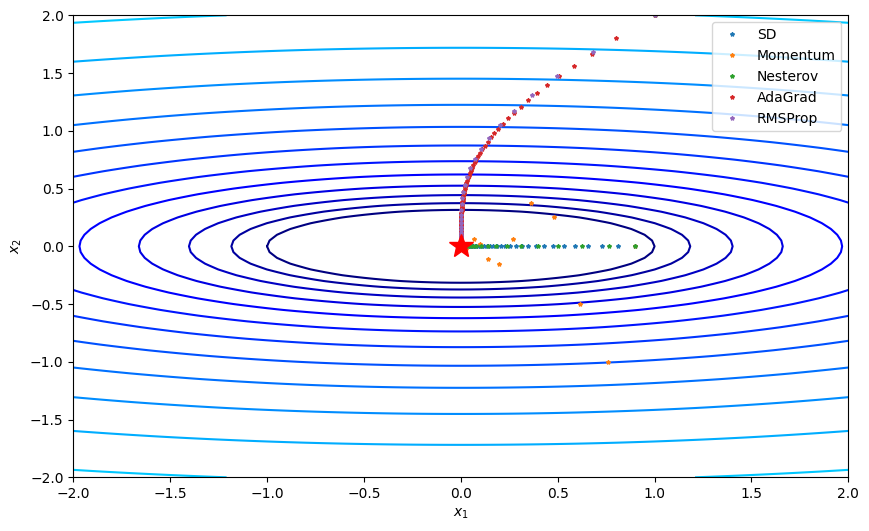

In [23]:
paths = {
    'SD': np.array(path_sg),
    'Momentum': np.array(path_mom),
    'Nesterov': np.array(path_nes),
    'AdaGrad': np.array(path_ada),
    'RMSProp': np.array(path_rms),
}

fig, ax = plt.subplots(figsize=(10, 6))
ax.contour(x1, x2, z, levels=np.logspace(0, 5, 35), norm=LogNorm(), cmap=plt.cm.jet)

for name, p in paths.items():
    ax.plot(p[:,0], p[:,1], marker='*', linestyle='None', markersize=3)

plt.legend(list(paths.keys()))
ax.plot(rez_rms[0], rez_rms[1], 'r*', markersize=18)

ax.set_xlabel('$x_1$')
ax.set_ylabel('$x_2$')
ax.set_xlim((xmin, xmax))
ax.set_ylim((ymin, ymax))
plt.show()


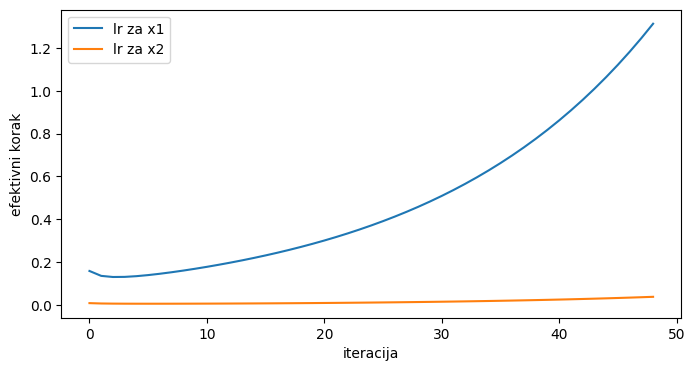

In [24]:
plt.figure(figsize=(8, 4))
plt.plot(lr_rms[:, 0], label='lr za x1')
plt.plot(lr_rms[:, 1], label='lr za x2')
plt.xlabel('iteracija')
plt.ylabel('efektivni korak')
plt.legend()
plt.show()


## ADAM

**ADAM** (*Adaptive Moment Estimation*) kombinuje ideje:
- momenta (pokretni prosek gradijenata),
- adaptacije koraka (pokretni prosek kvadrata gradijenata).

Definišu se dve pomoćne veličine:

\begin{align}
\mathbf{m}_k &= \beta_1\, \mathbf{m}_{k-1} + (1-\beta_1)\, \mathbf{g}_k, \\
\mathbf{v}_k &= \beta_2\, \mathbf{v}_{k-1} + (1-\beta_2)\, \mathbf{g}_k^2,
\end{align}

gde je $\mathbf{g}_k = \nabla f(\mathbf{x}_k)$, a kvadrat $\mathbf{g}_k^2$ se računa element-wise (po koordinatama).

Pošto su $\mathbf{m}_k$ i $\mathbf{v}_k$ inicijalno nule, uvodi se **bias-correction**:

\begin{align}
\hat{\mathbf{m}}_k = \frac{\mathbf{m}_k}{1-\beta_1^k}, \qquad
\hat{\mathbf{v}}_k = \frac{\mathbf{v}_k}{1-\beta_2^k}.
\end{align}

Ažuriranje parametara je:

\begin{align}
\mathbf{x}_{k+1} = \mathbf{x}_k - \gamma\, \frac{\hat{\mathbf{m}}_k}{\sqrt{\hat{\mathbf{v}}_k}+\varepsilon_1}.
\end{align}

Tipične vrednosti su $\beta_1=0.9$, $\beta_2=0.999$, a $\varepsilon_1 \approx 10^{-8}$.

In [25]:
def adam_gradient(gradf, x0, gamma=0.1, beta1=0.9, beta2=0.999, epsilon1=1e-8, epsilon=1e-6, max_iter=200):
    """Adam optimizer (sa bias-correction)."""
    x = np.asarray(x0, dtype=float).reshape(-1)
    m = np.zeros_like(x)
    v = np.zeros_like(x)
    path = [x.copy()]

    for t in range(1, max_iter + 1):
        g = np.asarray(gradf(x), dtype=float).reshape(-1)
        if np.linalg.norm(g) <= epsilon:
            break

        m = beta1 * m + (1 - beta1) * g
        v = beta2 * v + (1 - beta2) * (g * g)

        m_hat = m / (1 - beta1**t)
        v_hat = v / (1 - beta2**t)

        x = x - gamma * (m_hat / (np.sqrt(v_hat) + epsilon1))
        path.append(x.copy())

    return x, path


In [26]:
rez_adam, path_adam = adam_gradient(func1_grad, x0=[1, 2], gamma=0.1, beta1=0.9, beta2=0.999, epsilon1=1e-8, epsilon=1e-6, max_iter=200)
print('Rešenje (Adam):', rez_adam)
print('f(x) =', func1(rez_adam))


Rešenje (Adam): [-7.21798648e-06  5.69026734e-05]
f(x) = 3.2431241762677315e-08


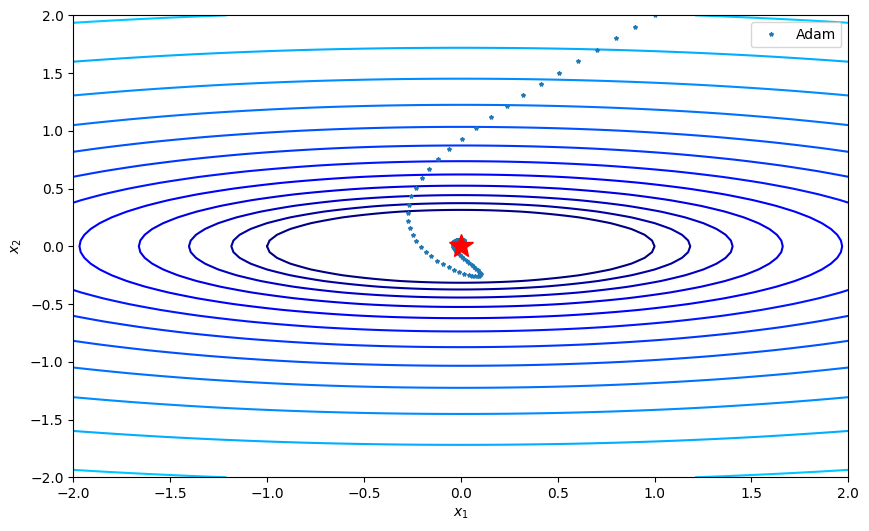

In [27]:
paths = {

    'Adam': np.array(path_adam),
}

fig, ax = plt.subplots(figsize=(10, 6))
ax.contour(x1, x2, z, levels=np.logspace(0, 5, 35), norm=LogNorm(), cmap=plt.cm.jet)

for name, p in paths.items():
    ax.plot(p[:,0], p[:,1], marker='*', linestyle='None', markersize=3)

plt.legend(list(paths.keys()))
ax.plot(rez_adam[0], rez_adam[1], 'r*', markersize=18)

ax.set_xlabel('$x_1$')
ax.set_ylabel('$x_2$')
ax.set_xlim((xmin, xmax))
ax.set_ylim((ymin, ymax))
plt.show()


# Newtonov metod

Newtonov metod koristi informacije **drugog reda** (Hesijan) da bi lokalno aproksimirao funkciju kvadratnom formom i napravio „pametan“ korak.

Tejlorova aproksimacija do drugog reda oko tačke $\mathbf{x}_k$:

\begin{align}
f(\mathbf{x}_k+\Delta\mathbf{x}) \approx f(\mathbf{x}_k) +
\nabla f(\mathbf{x}_k)^T \Delta\mathbf{x} +
\frac{1}{2}\Delta\mathbf{x}^T \mathbf{H}(\mathbf{x}_k)\, \Delta\mathbf{x}.
\end{align}

Stacionarna tačka ove kvadratne aproksimacije dobija se rešavanjem:

\begin{align}
\mathbf{H}(\mathbf{x}_k)\, \Delta\mathbf{x} = - \nabla f(\mathbf{x}_k),
\end{align}

pa je Newtonov korak:

\begin{align}
\Delta\mathbf{x} = -\mathbf{H}(\mathbf{x}_k)^{-1}\nabla f(\mathbf{x}_k),
\qquad
\mathbf{x}_{k+1} = \mathbf{x}_k + \Delta\mathbf{x}.
\end{align}

Prednosti:
- za konveksne kvadratne funkcije često konvergira u vrlo malom broju koraka,
- prirodno „skaluje“ različite ose preko Hesijana (koristi krivinu).

Mane:
- računanje i inverzija Hesijana je skupo u velikim dimenzijama,
- ako Hesijan nije pozitivan definitan (npr. sedlo), korak može biti problematičan.

In [28]:
def newton_method(gradf, hessf, x0, epsilon=1e-6, max_iter=50):
    """Newtonov metod: x_{k+1} = x_k - H^{-1}(x_k) * grad f(x_k)."""
    x = np.asarray(x0, dtype=float).reshape(-1)
    path = [x.copy()]

    for _ in range(max_iter):
        g = np.asarray(gradf(x), dtype=float).reshape(-1)
        H = np.asarray(hessf(x), dtype=float)

        # Rešavanje H p = g umesto eksplicitne inverzije (stabilnije)
        try:
            p = np.linalg.solve(H, g)
        except np.linalg.LinAlgError:
            # Ako je H singularan/loše uslovljen, prekidamo (ili bi se u praksi koristio damping)
            break

        x_new = x - p
        path.append(x_new.copy())

        if np.linalg.norm(x_new - x) <= epsilon:
            x = x_new
            break

        x = x_new

    return x, path


In [29]:
def func1_hessian(x):
    """Hesijan test funkcije: H = [[2,0],[0,20]] (konstantan)."""
    return np.array([[2.0, 0.0], [0.0, 20.0]])


In [30]:
rez_newton, path_newton = newton_method(func1_grad, func1_hessian, x0=[1, 2], epsilon=1e-12, max_iter=20)
print('Rešenje (Newton):', rez_newton)
print('f(x) =', func1(rez_newton))


Rešenje (Newton): [0. 0.]
f(x) = 0.0


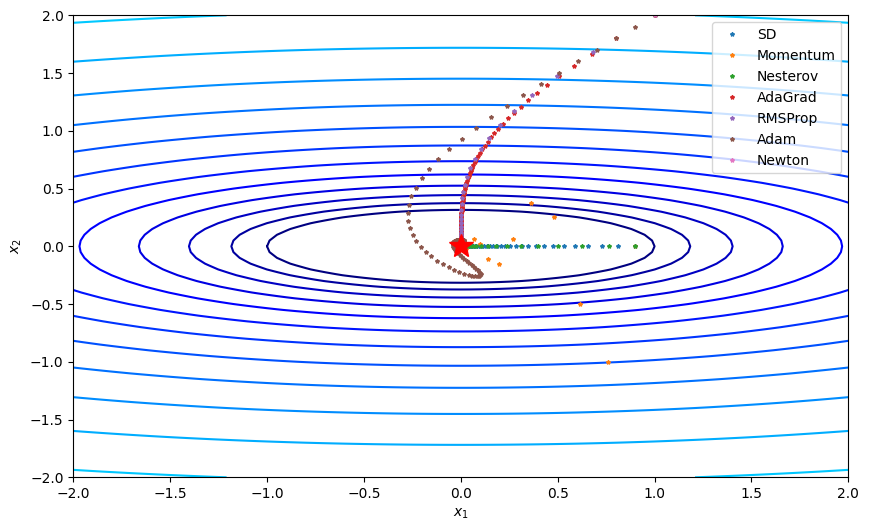

In [31]:
paths = {
    'SD': np.array(path_sg),
    'Momentum': np.array(path_mom),
    'Nesterov': np.array(path_nes),
    'AdaGrad': np.array(path_ada),
    'RMSProp': np.array(path_rms),
    'Adam': np.array(path_adam),
    'Newton': np.array(path_newton),
}

fig, ax = plt.subplots(figsize=(10, 6))
ax.contour(x1, x2, z, levels=np.logspace(0, 5, 35), norm=LogNorm(), cmap=plt.cm.jet)

for name, p in paths.items():
    ax.plot(p[:,0], p[:,1], marker='*', linestyle='None', markersize=3)

plt.legend(list(paths.keys()))
ax.plot(rez_newton[0], rez_newton[1], 'r*', markersize=18)

ax.set_xlabel('$x_1$')
ax.set_ylabel('$x_2$')
ax.set_xlim((xmin, xmax))
ax.set_ylim((ymin, ymax))
plt.show()
